#**IMDb Review Sentiment Classification**

##**Importation des bibliothèques**

In [1]:
#!pip install --upgrade gensim

In [2]:
from gensim.models import Word2Vec
import os
import numpy as np
import pandas as pd
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from nltk.tokenize import TreebankWordTokenizer
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

##**Chargement du Dataset "IMDb Dataset"**

In [3]:
df = pd.read_csv('train.csv')
print(f"Dimensions du dataset: {df.shape}")
df.head()

Dimensions du dataset: (25000, 3)


,Unnamed: 0,reviews,labels
0,0,Bromwell High is a cartoon comedy. It ran at t...,1
1,1,Homelessness (or Houselessness as George Carli...,1
2,2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,3,This is easily the most underrated film inn th...,1
4,4,This is not the typical Mel Brooks film. It wa...,1


## **Nettoyage des données**

In [4]:
tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Enlève les balises HTML
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Enlève la ponctuation et les chiffres
    text = text.lower()
    tokens = tokenizer.tokenize(text.lower())
    return [t for t in tokens if t.isalpha() and t not in stop_words]

df['tokens'] = df['reviews'].apply(preprocess)
df[['tokens', 'labels']].head()


,tokens,labels
0,"[bromwell, high, cartoon, comedy, ran, time, p...",1
1,"[homelessness, houselessness, george, carlin, ...",1
2,"[brilliant, acting, lesley, ann, warren, best,...",1
3,"[easily, underrated, film, inn, brooks, cannon...",1
4,"[typical, mel, brooks, film, much, less, slaps...",1


##**Distribution des classes**

In [5]:
import plotly.express as px

# Count the occurrences of each label
label_counts = df['labels'].value_counts().reset_index()
label_counts.columns = ['label', 'Nombre']

# Create the bar plot
fig = px.bar(label_counts, x='label', y='Nombre', title='Distribution des classes dans la colonne "labels"')

# Show the plot
fig.show()


##**Les mots les plus fréquents dans le dataset**

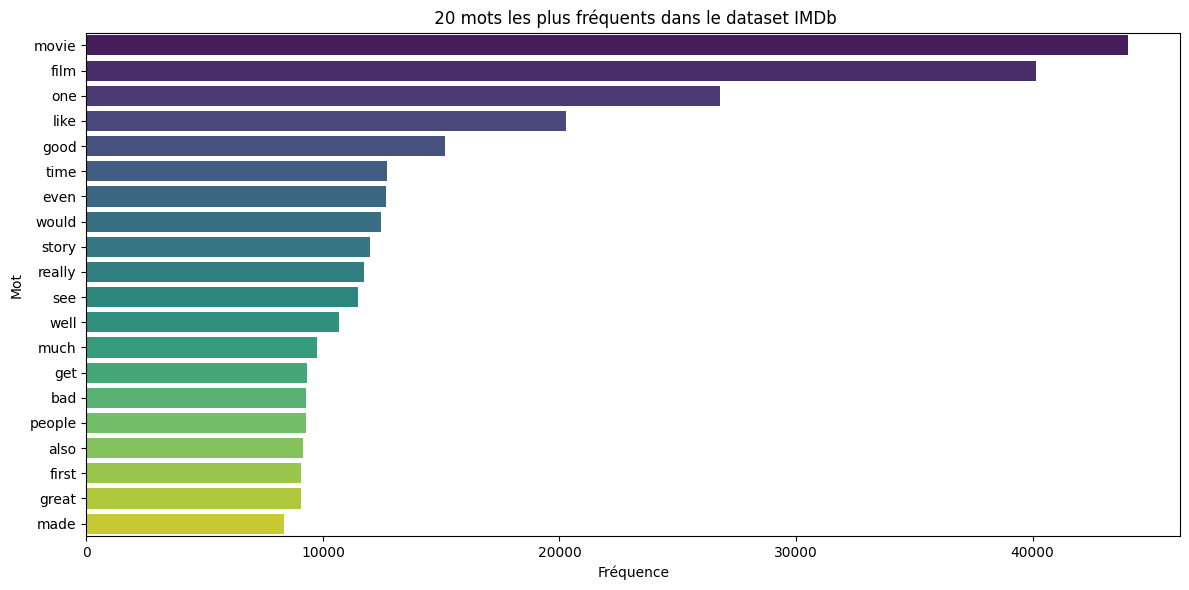

In [6]:
# Aplatir la liste de tokens pour tous les textes
all_tokens = [token for tokens in df['tokens'] for token in tokens]

# Compter la fréquence de chaque mot
word_freq = Counter(all_tokens)

# Obtenir les 20 mots les plus fréquents
most_common = word_freq.most_common(20)

# Séparer mots et fréquences
words, counts = zip(*most_common)

# Tracer un graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='viridis', legend=False)
plt.title(" 20 mots les plus fréquents dans le dataset IMDb")
plt.xlabel("Fréquence")
plt.ylabel("Mot")
plt.tight_layout()
plt.show()

##**Distribution de la lonquer**

In [7]:
df['text_length'] = df['reviews'].apply(lambda x: len(x.split()))
# Distribution de la longueur des commentaires avec Plotly
fig = px.histogram(df, x='text_length', nbins=50, title='Distribution de la longueur des commentaires')
fig.update_layout(
    xaxis_title='longueur des commentaires (nombre de mots)',
    yaxis_title='Fréquence'
)
fig.show()

In [8]:
import numpy as np
text_length = df['text_length']

print(f"Moyenne de la longueur des commentaires : {np.mean(text_length):.2f}")
print(f"Médiane de la longueur des commentaires : {np.median(text_length):.2f}")
print(f"90e percentile de la longueur des commentaires : {np.percentile(text_length, 90):.2f}")

Moyenne de la longueur des commentaires : 233.79
Médiane de la longueur des commentaires : 174.00
90e percentile de la longueur des commentaires : 458.00


##**Extraction des "N-Gram features"**

In [9]:
texts = [' '.join(tokens) for tokens in df['tokens']]

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_ngram = vectorizer.fit_transform(texts)
y = df['labels'].values

X_train_ngram, X_test_ngram, y_train, y_test = train_test_split(X_ngram, y, test_size=0.2, random_state=42)

print(f"Shape of X_train_ngram: {X_train_ngram.shape}")
print(f"Shape of X_test_ngram: {X_test_ngram.shape}")


Shape of X_train_ngram: (20000, 10000)
Shape of X_test_ngram: (5000, 10000)


##**Entrainement et évaluation du model N-Gram**

In [10]:
from sklearn.model_selection import GridSearchCV

# Define models and their parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    'RandomForestClassifier': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30]
    }),
    'LinearSVC': (LinearSVC(dual=False), {
        'C': [0.1, 1, 10, 100]
    })
}

results = {}

# Iterate through each model
for model_name, (model, param_grid) in models.items():
    print(f"Training and evaluating {model_name}...")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_ngram, y_train)

    # Get best model and evaluate
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_ngram)

    # Store results
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"Finished {model_name}")
    print("-" * 50)

# Print results for each model
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Best Parameters:", result['best_params'])
    print("Classification Report:\n", result['classification_report'])
    print("=" * 50)


Training and evaluating LogisticRegression...
Finished LogisticRegression
--------------------------------------------------
Training and evaluating RandomForestClassifier...
Finished RandomForestClassifier
--------------------------------------------------
Training and evaluating LinearSVC...
Finished LinearSVC
--------------------------------------------------
Model: LogisticRegression
Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2485
           1       0.89      0.90      0.89      2515

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Model: RandomForestClassifier
Best Parameters: {'max_depth': None, 'n_estimators': 500}
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86   

##**Extraction des Word2Vec Embeddings**

In [11]:
param_grid = {
    'vector_size': [100, 200, 300],
    'window': [5, 10],
    'min_count': [1, 5]
}

best_w2v_score = -1
best_w2v_params = {}
best_w2v_model = None
best_w2v_X_train = None
best_w2v_X_test = None

# Iterate through all combinations of hyperparameters
for vec_size in param_grid['vector_size']:
    for win in param_grid['window']:
        for m_count in param_grid['min_count']:
            print(f"Training Word2Vec with vector_size={vec_size}, window={win}, min_count={m_count}")

            # Train Word2Vec model
            current_w2v_model = Word2Vec(sentences=df['tokens'], vector_size=vec_size, window=win, min_count=m_count, workers=4)

            # Calculate average vectors for the current model
            def get_avg_vector(words, model):
                vectors = [model.wv[word] for word in words if word in model.wv]
                return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

            X_w2v_current = np.array([get_avg_vector(tokens, current_w2v_model) for tokens in df['tokens']])

            # Split data
            X_train_w2v_current, X_test_w2v_current, y_train_w2v, y_test_w2v = train_test_split(X_w2v_current, y, test_size=0.2, random_state=42)
            lr = LogisticRegression(max_iter=1000)
            lr.fit(X_train_w2v_current, y_train_w2v)
            score = lr.score(X_test_w2v_current, y_test_w2v)

            print(f"Evaluation score: {score}")

            # Keep track of the best model and parameters
            if score > best_w2v_score:
                best_w2v_score = score
                best_w2v_params = {'vector_size': vec_size, 'window': win, 'min_count': m_count}
                best_w2v_model = current_w2v_model
                best_w2v_X_train = X_train_w2v_current
                best_w2v_X_test = X_test_w2v_current

print("\nBest Word2Vec Parameters:", best_w2v_params)
print("Best Evaluation Score:", best_w2v_score)

Training Word2Vec with vector_size=100, window=5, min_count=1
Evaluation score: 0.8058
Training Word2Vec with vector_size=100, window=5, min_count=5
Evaluation score: 0.811
Training Word2Vec with vector_size=100, window=10, min_count=1
Evaluation score: 0.8106
Training Word2Vec with vector_size=100, window=10, min_count=5
Evaluation score: 0.817
Training Word2Vec with vector_size=200, window=5, min_count=1
Evaluation score: 0.8118
Training Word2Vec with vector_size=200, window=5, min_count=5
Evaluation score: 0.8148
Training Word2Vec with vector_size=200, window=10, min_count=1
Evaluation score: 0.817
Training Word2Vec with vector_size=200, window=10, min_count=5
Evaluation score: 0.8224
Training Word2Vec with vector_size=300, window=5, min_count=1
Evaluation score: 0.808
Training Word2Vec with vector_size=300, window=5, min_count=5
Evaluation score: 0.812
Training Word2Vec with vector_size=300, window=10, min_count=1
Evaluation score: 0.8174
Training Word2Vec with vector_size=300, win

##**Visualisation des Word2Vec embeddings avec PCA**

In [12]:
X_vis = PCA(n_components=2).fit_transform(best_w2v_X_train)

# Create a DataFrame for Plotly
df_pca = pd.DataFrame(X_vis, columns=['PC1', 'PC2'])
df_pca['Sentiment'] = y_train_w2v  # Assuming y_train_w2v corresponds to best_w2v_X_train

# Map the numerical labels to meaningful names for the legend
df_pca['Sentiment'] = df_pca['Sentiment'].map({0: 'Negative', 1: 'Positive'})

# Create the Plotly scatter plot
fig = px.scatter(df_pca, x='PC1', y='PC2', color='Sentiment',
                 title='Word2Vec Embeddings (PCA)',
                 labels={'PC1': 'PC1', 'PC2': 'PC2'},
                 color_discrete_map={'Negative': 'blue', 'Positive': 'red'},
                 opacity=0.5)

fig.show()

##**Visualisation des Word2Vec embeddings avec t-SNE**

In [13]:
words = list(best_w2v_model.wv.index_to_key[:500])
word_vecs = np.array([best_w2v_model.wv[word] for word in words])

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30.0, n_iter=300)
word_vecs_2d = tsne.fit_transform(word_vecs)

# Plot avec Plotly Express
fig = px.scatter(x=word_vecs_2d[:, 0], y=word_vecs_2d[:, 1], text=words,
                 title="Visualisation des embeddings Word2Vec (t-SNE)",
                 labels={'x': 't-SNE 1', 'y': 't-SNE 2'})

fig.update_traces(textposition='top center')
fig.update_layout(hovermode='closest')

fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



##**Entrainement et évaluation du model Word2Vec**

In [14]:
models_w2v = {
    'LogisticRegression_W2V': (LogisticRegression(max_iter=10000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    'RandomForestClassifier_W2V': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30]
    }),
    'LinearSVC_W2V': (LinearSVC(dual=False, max_iter=10000), {
        'C': [0.1, 1, 10, 100]
    })
}

results_w2v = {}

# Iterate through each model
for model_name, (model, param_grid) in models_w2v.items():
    print(f"Training and evaluating {model_name} with best Word2Vec embeddings...")

    # Perform GridSearchCV on the best Word2Vec embeddings
    grid_search_w2v = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    # Use the best_w2v_X_train and y_train_w2v from the previous step
    grid_search_w2v.fit(best_w2v_X_train, y_train_w2v)

    # Get best model and evaluate on the corresponding test set
    best_model_w2v = grid_search_w2v.best_estimator_
    # Use the best_w2v_X_test and y_test_w2v from the previous step
    y_pred_w2v = best_model_w2v.predict(best_w2v_X_test)

    # Store results
    results_w2v[model_name] = {
        'best_params': grid_search_w2v.best_params_,
        'classification_report': classification_report(y_test_w2v, y_pred_w2v)
    }

    print(f"Finished {model_name}")
    print("-" * 50)

# Print results for each model trained on Word2Vec embeddings
for model_name, result in results_w2v.items():
    print(f"Model: {model_name}")
    print("Best Parameters:", result['best_params'])
    print("Classification Report:\n", result['classification_report'])
    print("=" * 50)

Training and evaluating LogisticRegression_W2V with best Word2Vec embeddings...
Finished LogisticRegression_W2V
--------------------------------------------------
Training and evaluating RandomForestClassifier_W2V with best Word2Vec embeddings...
Finished RandomForestClassifier_W2V
--------------------------------------------------
Training and evaluating LinearSVC_W2V with best Word2Vec embeddings...
Finished LinearSVC_W2V
--------------------------------------------------
Model: LogisticRegression_W2V
Best Parameters: {'C': 100, 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      2485
           1       0.84      0.85      0.84      2515

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

Model: RandomForestClassifier_W2V
Best Parameters: {'max_depth': 20, 'n_estimators': 500}

##**Combinaison des features**

In [15]:
# Normalise les embeddings Word2Vec (best_w2v_X_train et best_w2v_X_test) avant de les combiner
scaler = StandardScaler()
X_w2v_train_scaled = scaler.fit_transform(best_w2v_X_train)
X_w2v_test_scaled = scaler.transform(best_w2v_X_test) # Use the same scaler fitted on training data

# Combine TF-IDF (sparse) + Word2Vec (dense) for both train and test sets
X_train_combined = hstack([X_train_ngram, X_w2v_train_scaled])
X_test_combined = hstack([X_test_ngram, X_w2v_test_scaled])

print(f"Shape of combined training features: {X_train_combined.shape}")
print(f"Shape of combined testing features: {X_test_combined.shape}")

Shape of combined training features: (20000, 10300)
Shape of combined testing features: (5000, 10300)


##**Entrainement et évaluation du model Combined**

In [16]:
models_combined = {
    'LogisticRegression_Combined': (LogisticRegression(max_iter=10000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    'RandomForestClassifier_Combined': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30]
    }),
    'LinearSVC_Combined': (LinearSVC(dual=False, max_iter=10000), {
        'C': [0.1, 1, 10, 100]
    })
}

results_combined = {}

# Iterate through each model for combined features
for model_name, (model, param_grid) in models_combined.items():
    print(f"Training and evaluating {model_name} with combined features...")

    grid_search_combined = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search_combined.fit(X_train_combined, y_train)

    # Get best model and evaluate on the corresponding test set
    best_model_combined = grid_search_combined.best_estimator_
    y_pred_combined = best_model_combined.predict(X_test_combined)

    # Store results
    results_combined[model_name] = {
        'best_params': grid_search_combined.best_params_,
        'classification_report': classification_report(y_test, y_pred_combined)
    }

    print(f"Finished {model_name}")
    print("-" * 50)

# Print results for each model trained on combined features
for model_name, result in results_combined.items():
    print(f"Model: {model_name}")
    print("Best Parameters:", result['best_params'])
    print("Classification Report:\n", result['classification_report'])
    print("=" * 50)

Training and evaluating LogisticRegression_Combined with combined features...
Finished LogisticRegression_Combined
--------------------------------------------------
Training and evaluating RandomForestClassifier_Combined with combined features...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Finished RandomForestClassifier_Combined
--------------------------------------------------
Training and evaluating LinearSVC_Combined with combined features...
Finished LinearSVC_Combined
--------------------------------------------------
Model: LogisticRegression_Combined
Best Parameters: {'C': 10, 'solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2485
           1       0.89      0.89      0.89      2515

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Model: RandomForestClassifier_Combined
Best Parameters: {'max_depth': None, 'n_estimators': 500}
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      2485
           1       0.79      0.83      0.81      2515

    accuracy                           

In [17]:
# Fonction pour tester le modèle sur une phrase exemple
def predict_sentiment(sentence, model, vectorizer_ngram, model_w2v, scaler_w2v):
    # Prétraiter la phrase
    tokens = preprocess(sentence)
    processed_sentence = ' '.join(tokens)

    # Extraire les features N-Gram
    X_ngram_test_sentence = vectorizer_ngram.transform([processed_sentence])

    # Extraire les Word2Vec embeddings
    def get_avg_vector(words, model):
        vectors = [model.wv[word] for word in words if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    X_w2v_test_sentence = np.array([get_avg_vector(tokens, model_w2v)])

    # Normaliser les Word2Vec embeddings
    X_w2v_test_sentence_scaled = scaler_w2v.transform(X_w2v_test_sentence)

    # Combiner les features
    X_test_sentence_combined = hstack([X_ngram_test_sentence, X_w2v_test_sentence_scaled])

    # Faire la prédiction
    prediction = model.predict(X_test_sentence_combined)

    # Interpréter la prédiction
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    return sentiment

test_sentence = "The film was a complete disappointment, slow-paced and poorly written"

if 'best_model_combined' in locals() and 'vectorizer' in locals() and 'best_w2v_model' in locals() and 'scaler' in locals():
    predicted_sentiment = predict_sentiment(test_sentence, best_model_combined, vectorizer, best_w2v_model, scaler)
    print(f"La phrase : '{test_sentence}'")
    print(f"Sentiment prédit : {predicted_sentiment}")
else:
    print("Les modèles et/ou transformateurs nécessaires ne sont pas encore entraînés ou définis. Veuillez exécuter les cellules précédentes.")


La phrase : 'The film was a complete disappointment, slow-paced and poorly written'
Sentiment prédit : Negative
